***From Raw Text to Business Insights: Applied Sentiment Analysis with LLMs***

**Introduction and Objectives**

This notebook aims to load Amazon Reviews on the product category of Books from the "bagadbilla/amazon-reviews-2023-trimmed" dataset on huggingface (see https://huggingface.co/datasets/bagadbilla/amazon-reviews-2023-trimmed).

That data is based on the data from https://amazon-reviews-2023.github.io/

**Citation**

Hou, Yupeng and Li, Jiacheng and He, Zhankui and Yan, An and Chen, Xiusi and McAuley, Julian (2024). Bridging Language and Items for Retrieval and Recommendation. arXiv preprint arXiv:2403.03952


In [5]:
# Install all necessary packages
!pip install datasets transformers evaluate scikit-learn pandas numpy datasets

**Step 1: Load Data and Create Smaller Subset**

In [9]:
# Import the necessary libraries
from datasets import load_dataset
import random
import json

# Load the Books reviews in streaming mode
dataset = load_dataset(
    "bagadbilla/amazon-reviews-2023-trimmed",
    data_dir="Books",
    split="train",
    streaming=True
)


# Fetch a sample of the first 500.000 reviews in the data for quicker exploration and data analysis
subset = []
for i, example in enumerate(dataset):
    rating = example.get("rating", None)  # get rating, default to None if missing
    
    # Skip if rating is 0 or None/NaN
    if rating in [0, None]:
        continue
    
    subset.append(example)
    
    if len(subset) >= 500_000:
        break
        
# Shuffle afterwards
random.shuffle(subset)

print("Collected 500k reviews")

# Take the first 5 reviews to inspect
for i, example in enumerate(subset):
    print(example)
    if i >= 4:
        break
        

# save subset of 500k samples as json
with open("amazon_books_subset_500k.json", "w", encoding="utf-8") as f:
    for item in subset:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

print("Saved 500k reviews to amazon_books_subset_500k.json")

Resolving data files:   0%|          | 0/299 [00:00<?, ?it/s]

Collected 500k reviews
{'rating': 5.0, 'title': 'Interpreted Painting', 'text': 'I am excited about this acrylic painting book. Very instructional and easy to follow. Written well and so easy to understand. I love the pics throughout to demonstrate techniques. I ordered this book new and received a new book, price was right and I am happy with the purchase. Thanks so much. Will do business with you guys in the future. :D'}
{'rating': 5.0, 'title': 'Five Stars', 'text': 'good'}
{'rating': 5.0, 'title': 'My favorite series even at 60.', 'text': 'I first found this series of book through the coloring book of the Mouse Guard. I was able to check out each book from the library and loved them all. There is something comforting in these beautifully illustrated stories that soothed my anxiety ridden soul. I love the detail that went into each page and character, the maps, the colors, everything.<br /> At my age they are still the books I keep by the side of my bed and when I wake up during nig

**Step 2: Subset Data Exploration**

In [10]:
import pandas as pd
import json

# Load the json subset into pandas for further processing

# Load JSONL file
data = []
with open("amazon_books_subset_500k.json", "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
print(df.head())

   rating                                title  \
0     5.0                 Interpreted Painting   
1     5.0                           Five Stars   
2     5.0       My favorite series even at 60.   
3     4.0                              Read it   
4     4.0  Decent story - wrong audio narrator   

                                                text  
0  I am excited about this acrylic painting book....  
1                                               good  
2  I first found this series of book through the ...  
3                 read it you won't be disappointed.  
4  ane Whitefield  a 30-something part Seneca wom...  


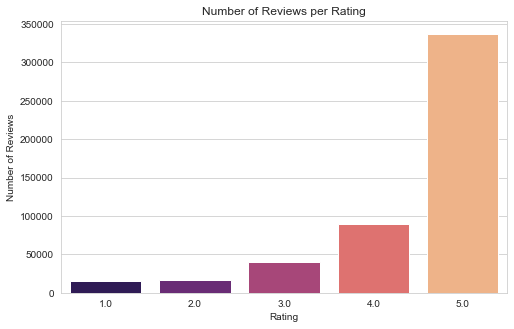

In [12]:
import matplotlib.pyplot as plt

# Count reviews per rating
rating_counts = df['rating'].value_counts().sort_index()

# Plot
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="magma")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.title("Number of Reviews per Rating")
plt.show()

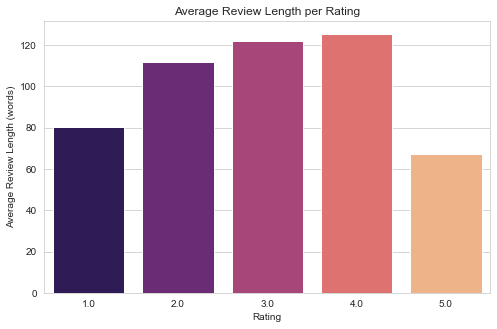

In [13]:
# Compute review lengths (in words)
df['review_length'] = df['text'].apply(lambda x: len(x.split()))

# Group by rating and compute mean
avg_lengths = df.groupby('rating')['review_length'].mean().reset_index()

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='rating', y='review_length', data=avg_lengths, palette="magma")
plt.xlabel("Rating")
plt.ylabel("Average Review Length (words)")
plt.title("Average Review Length per Rating")
plt.show()

Found 0 reviews with rating 0
Empty DataFrame
Columns: [rating, title, text, review_length]
Index: []


**Step 3: Sentiment Analysis Methods**